<a href="https://colab.research.google.com/github/Atefeh1/machine_learning_projects/blob/main/trianing_CNN_using_wandb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


Download and load the EMNIST dataset. Preprocess the data: normalization, reshaping

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset1 = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_dataset = EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

print(f'Train dataset size: {len(train_dataset1)}')
print(f'Test dataset size: {len(test_dataset)}')

classes = train_dataset1.classes
print(f'Classes:\n{classes}')




100%|██████████| 562M/562M [00:02<00:00, 281MB/s]


Train dataset size: 112800
Test dataset size: 18800
Classes:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


Visualize some sample images to understand the dataset.

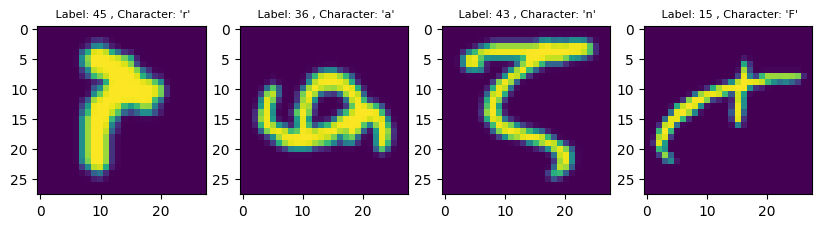

In [ ]:
fig,ax=plt.subplots(1, 4,figsize=(10,4))
for i in range(4):
  x,y=train_dataset1[i]
  class_name=classes[y]
  ax[i].imshow(x[0,:,:])
  ax[i].set_title(f" Label: {y} , Character: '{class_name}'", fontsize=8)


creating train/validation/test splits.

In [ ]:
train_size = int(0.8 * len(train_dataset1))
val_size = len(train_dataset1) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset1, [train_size, val_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
# Iterate over the data
for x, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
def plot_results(train_losses, train_accs, val_losses, val_accs):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    xs = np.arange(1, len(train_losses) + 1, 1)
    axes[0].plot(xs, train_losses, label='Train')
    axes[0].plot(xs, val_losses, label='Validation')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_accs, label='Train')
    axes[1].plot(xs, val_accs, label='Validation')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xticks(xs)
    plt.tight_layout()
    plt.legend()
    plt.show()

defining convolutional neural network

In [ ]:
class ConvNN(nn.Module):
    def __init__(self, num_classes):
        super(ConvNN, self).__init__()

        self.network = nn.Sequential(
            # --- Convolution layers ---
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # (1,28,28) -> (32,28,28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # (32,28,28) -> (64,28,28)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (64,14,14)

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # (64,14,14) -> (128,14,14)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (128,7,7)

            nn.Flatten(),

            # --- Fully Connected layers ---
            nn.Linear(128 * 7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.20),

            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.network(x)

defining train, test and validation steps and how to train model

In [ ]:
def train_step(model, criterion, optimizer, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.train()
    # Iterate over the dataloader
    for x, y in dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = criterion(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the running loss
        running_loss += loss.item()
        # Update the correctly predicted counter
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

def val_step(model, criterion, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.eval()
    # Iterate over the dataloader
    with torch.no_grad():
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Compute prediction error
          loss = criterion(pred, y)
          # Update the running loss
          running_loss += loss.item()
          # Update the correctly predicted counter
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def test_step(model, criterion, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.eval()
    targets=[]
    preds=[]
    # Disable gradient calculation
    with torch.no_grad():
      # Iterate over the dataloader
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          pred_labels = pred.argmax(dim=1)
          # Update the running loss
          running_loss += criterion(pred, y).item()
          # Update the correctly predicted counter
          correct += (pred_labels == y).type(torch.float).sum().item()
          targets.extend(y.cpu().numpy())
          preds.extend(pred_labels.cpu().numpy())
    print("confusion matrix:")
    print(confusion_matrix(targets,preds))
    print("classification report:")
    print(classification_report(targets,preds))
    # Calculate and return the average accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def train_model(model, n_epochs, optimizer, train_loader,val_loader, device=device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc=0
    for epoch in (pbar := trange(n_epochs)):
        # Train the model
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        # Evaluate the model
        val_loss, val_acc = val_step(model, criterion, val_loader, device)
        # Display the results
        pbar.set_description(f'Train Loss = {train_loss:.3f} | Train Acc = {train_acc:.2f}% | Validation Loss = {val_loss:.3f} | Validation Acc = {val_acc:.2f}% ')
        # Store the results
        train_losses.append(train_loss), train_accs.append(train_acc), val_losses.append(val_loss), val_accs.append(val_acc)
        if val_acc > best_acc:
          best_acc = val_acc
          torch.save(model.state_dict(), "best_model.pth")
    # Plot the results
    plot_results(train_losses, train_accs, val_losses, val_accs)
    return {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs}

train and test model

Train Loss = 0.341 | Train Acc = 88.33% | Validation Loss = 0.350 | Validation Acc = 88.44% : 100%|██████████| 20/20 [11:23<00:00, 34.19s/it]


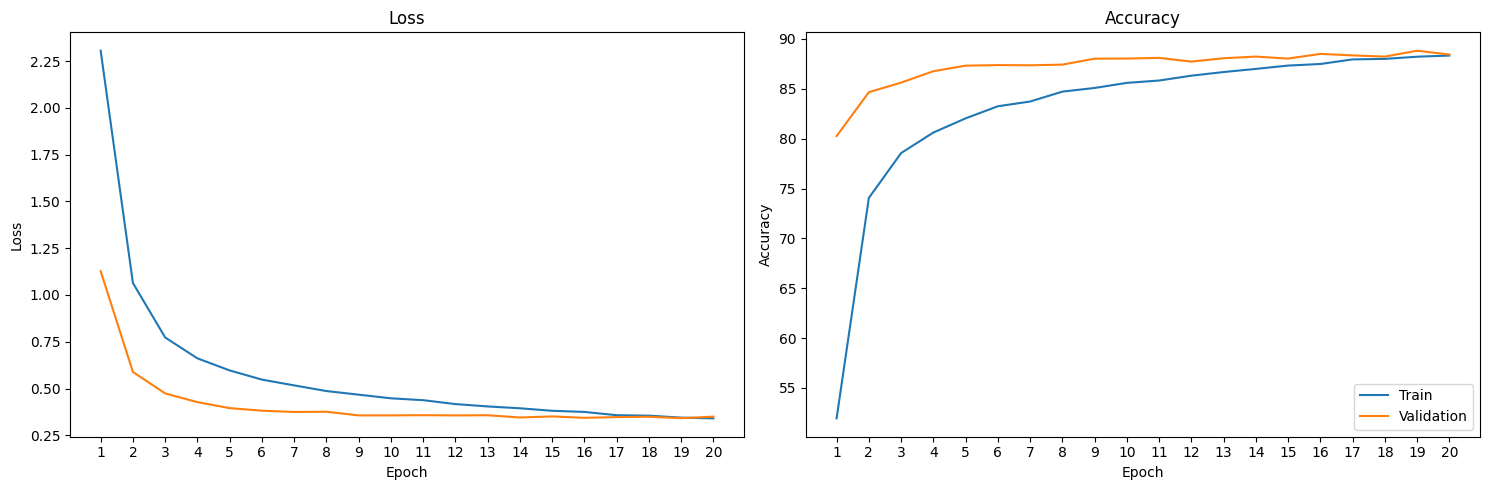

confusion matrix:
[[321   0   0 ...   0   0   0]
 [  0 267   0 ...   0   0   1]
 [  0   0 353 ...   0   0   0]
 ...
 [  0   0   1 ... 226   0   1]
 [  0   0   0 ...   0 381   0]
 [  0   0   0 ...   0   5 367]]
classification report:
              precision    recall  f1-score   support

           0       0.62      0.80      0.70       400
           1       0.56      0.67      0.61       400
           2       0.92      0.88      0.90       400
           3       0.98      0.99      0.98       400
           4       0.94      0.90      0.92       400
           5       0.92      0.91      0.91       400
           6       0.93      0.94      0.94       400
           7       0.97      0.98      0.98       400
           8       0.94      0.95      0.94       400
           9       0.69      0.84      0.76       400
          10       0.94      0.97      0.96       400
          11       0.97      0.96      0.97       400
          12       0.96      0.95      0.96       400
          

In [ ]:
model = ConvNN(num_classes=len(classes)).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)

results = train_model(model, 20, optimizer, train_loader, val_loader)
criterion = nn.CrossEntropyLoss()
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc, = test_step(model, criterion, test_loader)
print(f"test_loss={test_loss} and test_accuracy ={test_acc}")


Set up wandb to log metrics such as training/validation loss and accuracy.

In [ ]:
import wandb
import os

# Login to wandb (you'll need an API key from https://wandb.ai/authorize)
wandb.login()

# Set up environment variables (optional but recommended)
os.environ["WANDB_PROJECT"] = "cnn-experiments"  # Name of the project
os.environ["WANDB_ENTITY"] = "Atefeh"     # username or team name
os.environ["WANDB_LOG_MODEL"] = "true"          # Log model checkpoints
os.environ["WANDB_WATCH"] = "all"               # Log all gradients and parameters

# 1. Initialize wandb
wandb.init(
    project="cnn",
    name="Integrating-wandb",
    notes="CNN model for image classification using wandb to log metrics such as training/validation loss and accuracy",
    config={
        "learning_rate": 0.001,
        "batch_size": 64,
        "epochs": 20,
        "optimizer": "Adam",
        "architecture": "customCNN",
        "dataset": "EMNIST"
    }
)

# 2. Access config parameters
config = wandb.config


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
def train_step(model, criterion, optimizer, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.train()
    # Iterate over the dataloader
    for x, y in dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = criterion(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the running loss
        running_loss += loss.item()
        # Update the correctly predicted counter
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

def val_step(model, criterion, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.eval()
    # Iterate over the dataloader
    with torch.no_grad():
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Compute prediction error
          loss = criterion(pred, y)
          # Update the running loss
          running_loss += loss.item()
          # Update the correctly predicted counter
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def test_step(model, criterion, dataloader, device=device,class_names=classes):
    running_loss, correct = 0, 0
    preds = []
    targets = []
    # Move the model to training mode
    model.eval()
    # Disable gradient calculation
    with torch.no_grad():
      # Iterate over the dataloader
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          pred_labels = pred.argmax(dim=1)
          # Update the running loss
          running_loss += criterion(pred, y).item()
          # Update the correctly predicted counter
          correct += (pred_labels == y).type(torch.float).sum().item()
          preds.extend(pred_labels.cpu().numpy())
          targets.extend(y.cpu().numpy())

    # Log confusion matrix
    wandb.log({"conf_mat": wandb.plot.confusion_matrix(
        y_true=targets,
        preds=preds,
        class_names=class_names
    )})
    class_report=classification_report(targets,preds,target_names=class_names,output_dict=True)

    report = []
    for class_name in class_names:
        # Get metrics using the class name as key (thanks to target_names)
        metrics = class_report[class_name]
        report.append([
            class_name,
            f"{metrics['precision']:.4f}",
            f"{metrics['recall']:.4f}",
            f"{metrics['f1-score']:.4f}",
            metrics['support']
        ])

    wandb.log({"classification_report": wandb.Table(
        columns=["Class", "Precision", "Recall", "F1-Score", "Support"],data=report)})
    # Calculate and return the average accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def train_model(model, n_epochs, optimizer, train_loader,val_loader, device=device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc=0
    for epoch in (pbar := trange(n_epochs)):
        # Train the model
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        # Evaluate the model
        val_loss, val_acc = val_step(model, criterion, val_loader, device)
        # Display the results
        pbar.set_description(f'Train Loss = {train_loss:.3f} | Train Acc = {train_acc:.2f}% | Validation Loss = {val_loss:.3f} | Validation Acc = {val_acc:.2f}% ')
        # Store the results
        train_losses.append(train_loss), train_accs.append(train_acc), val_losses.append(val_loss), val_accs.append(val_acc)
        # Log metrics to wandb
        wandb.log({
                    "epoch": epoch,
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                    "learning_rate": optimizer.param_groups[0]['lr']
                  })
        if val_acc > best_acc:
          best_acc = val_acc
          torch.save(model.state_dict(), "best_model.pth")
          wandb.save("best_model.pth")  # Save to wandb
    # Plot the results
    plot_results(train_losses, train_accs, val_losses, val_accs)
    wandb.log({"best_val_acc": val_acc})
    return {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs}

Train Loss = 0.230 | Train Acc = 91.15% | Validation Loss = 0.375 | Validation Acc = 89.03% : 100%|██████████| 20/20 [11:21<00:00, 34.07s/it]


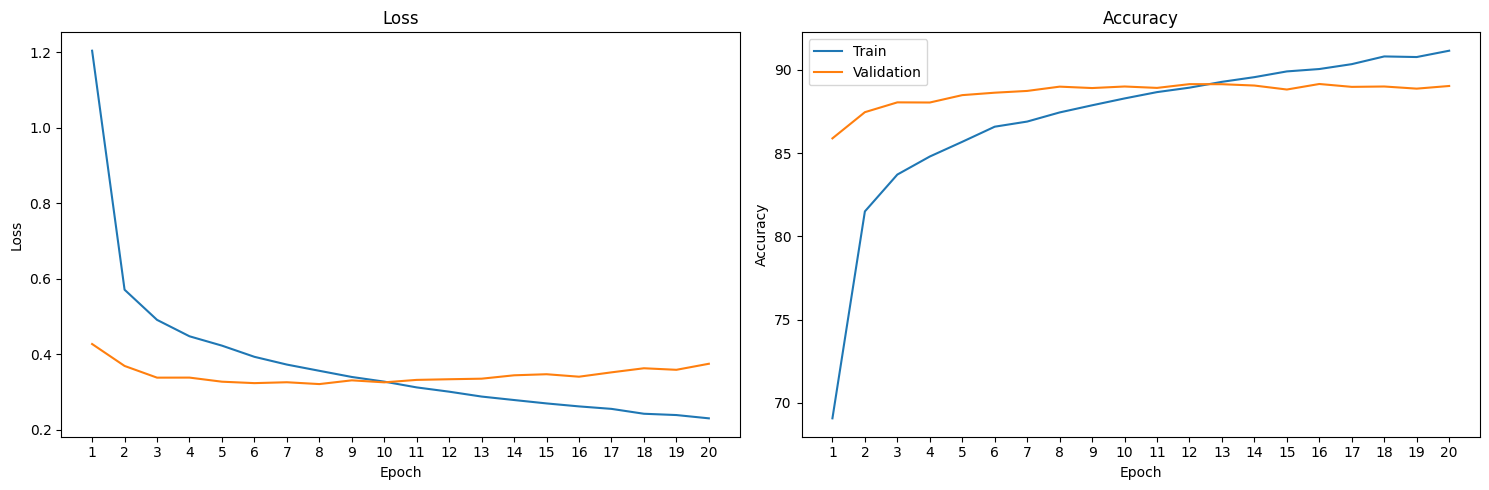

test_loss=0.37148736751809414 and test_accuracy =88.54787234042553


best_val_acc,█▁▄
epoch,▁▁▂▂▃▄▄▅▆▇▇██▁▂▃▄▄▄▅▅▆▇▇█▁▁▂▂▂▃▄▄▅▅▆▆▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▆▆▆▇▇▇▇▇▇█▁▅▆▆▇▇▇▇▇▇████▁▅▆▆▆▇▇▇▇▇▇████
train_loss,█▃▃▃▂▂▂▂▂▂▁▁▁▁▁█▃▃▂▂▂▂▂▁▁▁▁▁▁█▂▂▂▂▂▂▁▁▁▁
val_acc,▁▃▆▆▇▇▇█▇███▇█▁▆▇▇▇█▇▇█▇██▁▄▆▇█▇█▇█▇████
val_loss,█▅▃▂▂▁▁▁▂▂▂▃▃▃▄█▄▂▂▂▁▁▁▂▂▃▃▃█▄▂▁▁▁▁▂▃▃▃▄
best_val_acc,89.03369
epoch,19


In [ ]:
model = ConvNN(num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

results = train_model(model, config.epochs, optimizer, train_loader, val_loader)
criterion = nn.CrossEntropyLoss()
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = test_step(model, criterion, test_loader,device=device,class_names=classes)
print(f"test_loss={test_loss} and test_accuracy ={test_acc}")
wandb.log({"test_acc": test_acc})
wandb.log({"test_loss": test_loss})
wandb.finish()  # End the wandb run


Use wandb sweeps to systematically tune the following hyperparameters:
* Learning rate
* Optimizer (SGD, Adam)
* Batch size (8, 16, 32, 64, 128)
* Number of convolution filters
* Dropout rate
* Kernel size / number of layers

In [ ]:
class convNN(nn.Module):
    """Flexible CNN architecture that can be configured via hyperparameters"""
    def __init__(self, config, num_classes):
        super(convNN, self).__init__()


        # EMNIST image size is 28x28
        input_size = 28
        output_size = input_size

        # Build convolutional layers
        layers = []
        in_channels = 1  # EMNIST is grayscale
        stride=1
        padding=1
        pool_size=2
        for i in range(config["num_conv_layers"]):

            # Add convolutional layer
            layers.append(nn.Conv2d(in_channels,config["filters"] * (2 ** i),
                                    kernel_size=config["kernel_size"],padding=config["kernel_size"] // 2))
            layers.append(nn.BatchNorm2d(config["filters"] * (2 ** i)))
            layers.append(nn.ReLU())
            if i%2==0:
              layers.append(nn.MaxPool2d(2))

            # Update channel count for next layer
            in_channels = config["filters"] * (2 ** i)


        dummy_input = torch.zeros(1, 1, 28, 28)  # (batch, channels, height, width)
        with torch.no_grad():
            featuremap_size = nn.Sequential(*layers)(dummy_input)

        self.flattened_size = int(torch.prod(torch.tensor(featuremap_size.shape[1:])))

        # Build classifier
        self.network = nn.Sequential(*layers,
            nn.Flatten(),
            nn.Linear(self.flattened_size, config["dense_units"]),
            nn.ReLU(),
            nn.Dropout(config["dropout_rate"]),
            nn.Linear(config["dense_units"], config["dense_units"]//4),
            nn.BatchNorm1d(config["dense_units"]//4),
            nn.ReLU(),
            nn.Dropout(config["dropout_rate"]),
            nn.Linear(config["dense_units"]//4, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [ ]:
def train_step(model, criterion, optimizer, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.train()
    # Iterate over the dataloader
    for x, y in dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = criterion(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the running loss
        running_loss += loss.item()
        # Update the correctly predicted counter
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

def val_step(model, criterion, dataloader, device=device):
    running_loss, correct = 0, 0
    preds = []
    targets = []
    # Move the model to training mode
    model.eval()
    # Iterate over the dataloader
    with torch.no_grad():
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          pred_label=pred.argmax(1)
          # Compute prediction error
          loss = criterion(pred, y)
          # Update the running loss
          running_loss += loss.item()
          # Update the correctly predicted counter
          correct += (pred_label == y).type(torch.float).sum().item()
          preds.extend(pred_label.cpu().numpy())
          targets.extend(y.cpu().numpy())
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset),preds,targets


def test_step(model, criterion, dataloader, device=device,class_names=None):
    running_loss, correct = 0, 0
    preds = []
    targets = []
    # Move the model to training mode
    model.eval()
    # Disable gradient calculation
    with torch.no_grad():
      # Iterate over the dataloader
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          pred_label=pred.argmax(1)
          # Update the running loss
          running_loss += criterion(pred, y).item()
          # Update the correctly predicted counter
          correct += (pred_label == y).type(torch.float).sum().item()
          preds.extend(pred_label.cpu().numpy())
          targets.extend(y.cpu().numpy())

    # Log confusion matrix
    wandb.log({"test_conf_mat": wandb.plot.confusion_matrix(y_true=targets,preds=preds,class_names=class_names)})
    class_report=classification_report(targets,preds,target_names=class_names,output_dict=True)

    report = []
    for class_name in class_names:
        # Get metrics using the class name as key (thanks to target_names)
        metrics = class_report[class_name]
        report.append([class_name,f"{metrics['precision']:.4f}",f"{metrics['recall']:.4f}",
                       f"{metrics['f1-score']:.4f}",metrics['support']])

    wandb.log({"test_classification_report": wandb.Table(
               columns=["Class", "Precision", "Recall", "F1-Score", "Support"],data=report)})

    # Calculate and return the average accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def train_model(config=None):
    run = wandb.init()
    config = wandb.config  # Access all hyperparameters through wandb.config
    torch.manual_seed(42)
    np.random.seed(42)
    global train_dataset, val_dataset, test_dataset, classes
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    train_loader = DataLoader(dataset=train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=config["batch_size"], shuffle=False)

    criterion = nn.CrossEntropyLoss()
    num_classes=len(classes)
    model = convNN(config, num_classes).to(device)
    # Define optimizer based on config
    if config.optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(),lr=config.learning_rate,
                               weight_decay=config.get("weight_decay", 0.0))
    else:  # SGD
        optimizer = optim.SGD(model.parameters(),lr=config.learning_rate,
                              momentum=config.get("momentum", 0.9),weight_decay=config.get("weight_decay", 0.0))
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max',patience=3,factor=0.5,)

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc=0
    # Training loop
    for epoch in (pbar := trange(config.epochs)):
      # Train the model
      train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
      # Evaluate the model
      val_loss, val_acc, val_preds, val_targets = val_step(model, criterion, val_loader, device)
      # Display the results
      pbar.set_description(f'Train Loss = {train_loss:.3f} | Train Acc = {train_acc:.2f}% | Validation Loss = {val_loss:.3f} | Validation Acc = {val_acc:.2f}% ')
      # Store the results
      train_losses.append(train_loss), train_accs.append(train_acc), val_losses.append(val_loss), val_accs.append(val_acc)
      # Log metrics to wandb
      wandb.log({"epoch": epoch,"train_loss": train_loss,"train_acc": train_acc,"val_loss": val_loss,"val_acc": val_acc,
                 "learning_rate": optimizer.param_groups[0]['lr']})
      # Update learning rate
      scheduler.step(val_acc)
      if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        artifact = wandb.Artifact(f"best-model-epoch{epoch}", type="model")
        artifact.add_file("best_model.pth")
        wandb.log_artifact(artifact)
        wandb.log({"val_conf_mat": wandb.plot.confusion_matrix(y_true=val_preds,preds=val_targets,class_names=classes)})
        # Plot the results
    plot_results(train_losses, train_accs, val_losses, val_accs)
    wandb.log({"best_val_acc": best_acc})
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = test_step(model, criterion, test_loader,device=device,class_names=classes)
    print(f"test_loss={test_loss} and test_accuracy ={test_acc}")
    wandb.log({"test_acc": test_acc})
    wandb.log({"test_loss": test_loss})
    return {"val_acc": best_acc,"test_acc": test_acc,"test_loss": test_loss}



Create sweep with ID: s5a5vhx8
Sweep URL: https://wandb.ai/atefehziaei02-amirkabir-university-of-technology/sweep-cnn-emnist/sweeps/s5a5vhx8
Sweep ID: s5a5vhx8
Starting 20 runs for hyperparameter sweep...


wandb: Agent Starting Run: pv76np1c with config:
wandb: 	batch_size: 128
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2535871140960844
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0017345470160425225
wandb: 	momentum: 0.8939671305637812
wandb: 	num_conv_layers: 3
wandb: 	optimizer: Adam
wandb: 	weight_decay: 3.082271933749413e-05


Using device: cuda


Train Loss = 0.492 | Train Acc = 81.95% | Validation Loss = 0.392 | Validation Acc = 87.96% : 100%|██████████| 20/20 [09:59<00:00, 29.99s/it]


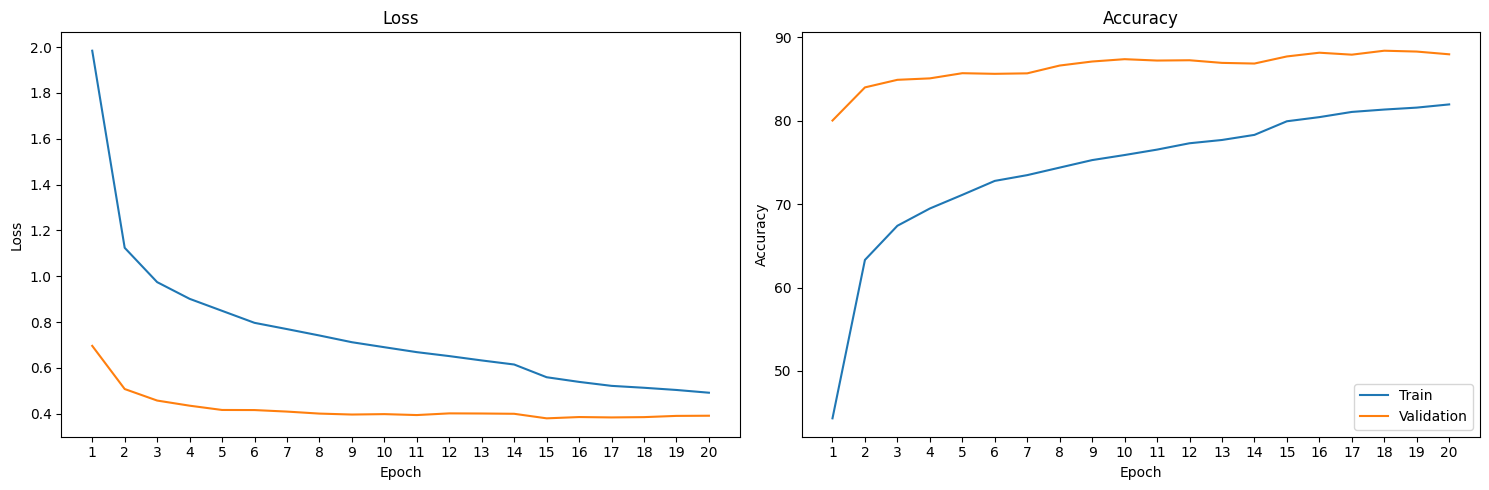

test_loss=0.3965029622219047 and test_accuracy =87.97340425531915


best_val_acc,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,██████████████▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▅▆▆▆▆▇▇▇▇▇▇▇██████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇█████
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,88.39096
epoch,19


wandb: Agent Starting Run: dipypdx3 with config:
wandb: 	batch_size: 16
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.44743966114165656
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	kernel_size: 5
wandb: 	learning_rate: 1.676450173592932e-06
wandb: 	momentum: 0.802376729483429
wandb: 	num_conv_layers: 1
wandb: 	optimizer: Adam
wandb: 	weight_decay: 1.724881861402507e-06


Using device: cuda


Train Loss = 1.864 | Train Acc = 66.81% | Validation Loss = 1.498 | Validation Acc = 78.77% : 100%|██████████| 20/20 [15:03<00:00, 45.16s/it]


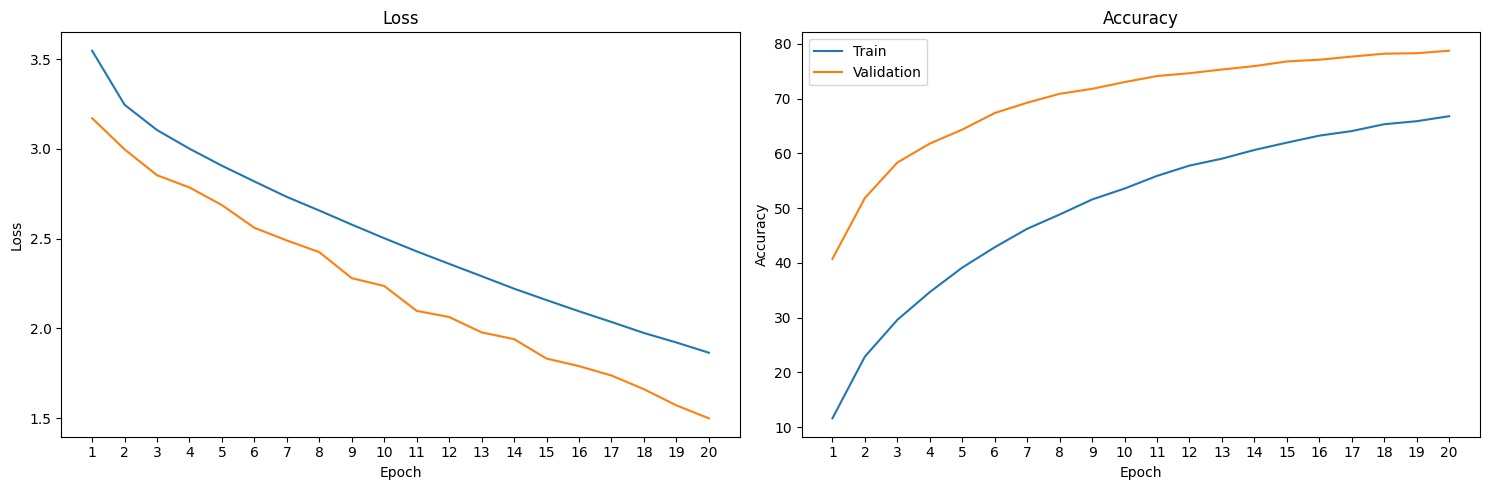

test_loss=1.500398185050234 and test_accuracy =78.57978723404256


best_val_acc,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇█████
train_loss,█▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
val_acc,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████
val_loss,█▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁
best_val_acc,78.77216
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q6itdruw with config:
wandb: 	batch_size: 8
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.5667511948214492
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	kernel_size: 5
wandb: 	learning_rate: 1.6969729150249564e-05
wandb: 	momentum: 0.8175952454378963
wandb: 	num_conv_layers: 3
wandb: 	optimizer: SGD
wandb: 	weight_decay: 4.917512918671157e-06


Using device: cuda


Train Loss = 2.258 | Train Acc = 38.73% | Validation Loss = 1.276 | Validation Acc = 82.57% : 100%|██████████| 20/20 [30:06<00:00, 90.30s/it]


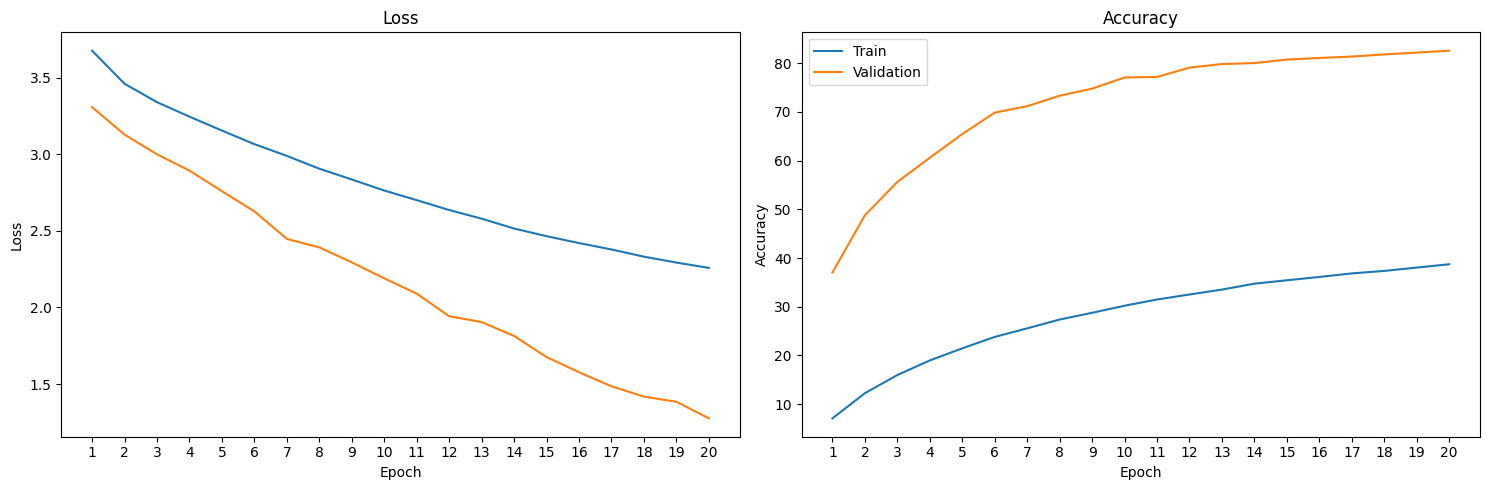

test_loss=1.278407856961514 and test_accuracy =82.31382978723404


best_val_acc,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇████
train_loss,█▇▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁
val_acc,▁▃▄▅▅▆▆▇▇▇▇▇████████
val_loss,█▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁
best_val_acc,82.57092
epoch,19


wandb: Agent Starting Run: molr9jl1 with config:
wandb: 	batch_size: 128
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3449048576705347
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.005061118143442623
wandb: 	momentum: 0.9365610461967886
wandb: 	num_conv_layers: 3
wandb: 	optimizer: Adam
wandb: 	weight_decay: 3.817927639122684e-06


Using device: cuda


Train Loss = 0.651 | Train Acc = 77.02% | Validation Loss = 0.439 | Validation Acc = 87.82% : 100%|██████████| 20/20 [16:48<00:00, 50.44s/it]


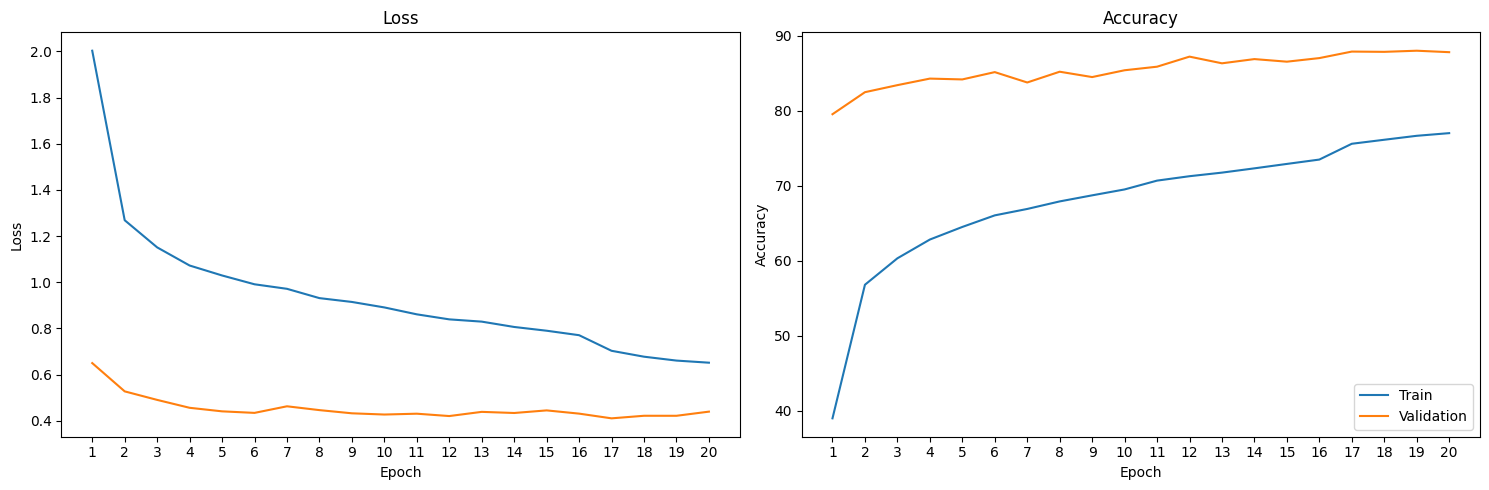

test_loss=0.4192540877733101 and test_accuracy =87.98404255319149


best_val_acc,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,████████████████▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
train_loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
val_acc,▁▃▄▅▅▆▄▆▅▆▆▇▇▇▇▇████
val_loss,█▄▃▂▂▂▃▂▂▁▂▁▂▂▂▂▁▁▁▂
best_val_acc,88.01862
epoch,19


wandb: Agent Starting Run: rhsyurjf with config:
wandb: 	batch_size: 64
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3243620841094502
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003352823839688099
wandb: 	momentum: 0.9432346099527608
wandb: 	num_conv_layers: 4
wandb: 	optimizer: SGD
wandb: 	weight_decay: 2.28715185847108e-05


Using device: cuda


Train Loss = 0.883 | Train Acc = 68.73% | Validation Loss = 0.414 | Validation Acc = 85.91% : 100%|██████████| 20/20 [13:16<00:00, 39.80s/it]


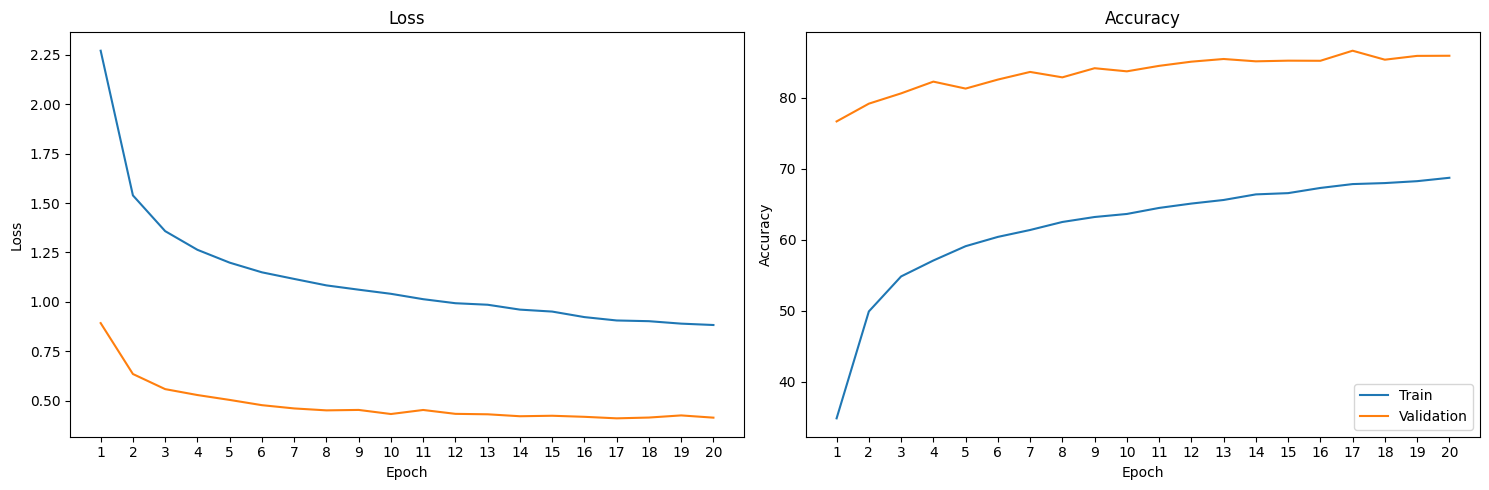

test_loss=0.42133454142176374 and test_accuracy =86.2872340425532


best_val_acc,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▄▅▆▆▆▆▇▇▇▇▇▇███████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▃▄▅▄▅▆▅▆▆▇▇▇▇▇▇█▇▇█
val_loss,█▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
best_val_acc,86.62234
epoch,19


wandb: Agent Starting Run: rx48rm0g with config:
wandb: 	batch_size: 128
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.35996303545846653
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.004429642712960431
wandb: 	momentum: 0.934179963151746
wandb: 	num_conv_layers: 4
wandb: 	optimizer: SGD
wandb: 	weight_decay: 1.522000219206854e-06


Using device: cuda


Train Loss = 0.374 | Train Acc = 86.56% | Validation Loss = 0.345 | Validation Acc = 88.83% : 100%|██████████| 20/20 [12:36<00:00, 37.85s/it]


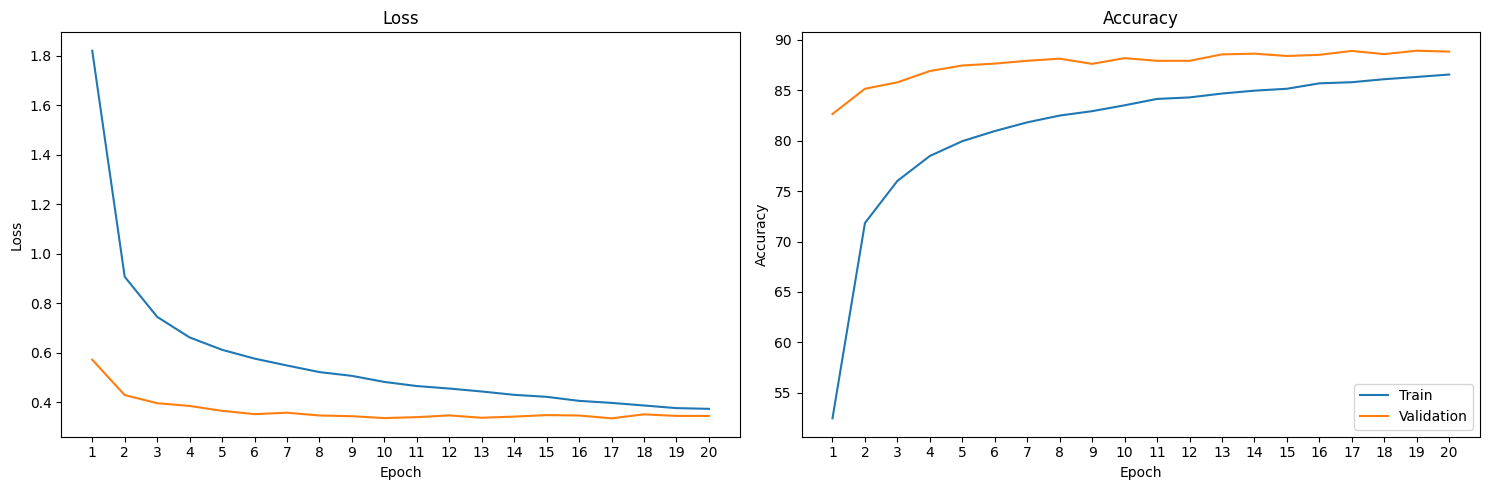

test_loss=0.3447142146071609 and test_accuracy =88.73936170212765


best_val_acc,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▆▆▇▇▇▇▇▇██████████
train_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▆▇▇▇▇▇▇▇██▇█████
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,88.92287
epoch,19


wandb: Agent Starting Run: tad4346m with config:
wandb: 	batch_size: 128
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.4802695120075685
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.007956022482874836
wandb: 	momentum: 0.9037205723828028
wandb: 	num_conv_layers: 3
wandb: 	optimizer: SGD
wandb: 	weight_decay: 2.3778895947802283e-08


Using device: cuda


Train Loss = 0.757 | Train Acc = 73.39% | Validation Loss = 0.380 | Validation Acc = 86.29% : 100%|██████████| 20/20 [11:31<00:00, 34.55s/it]


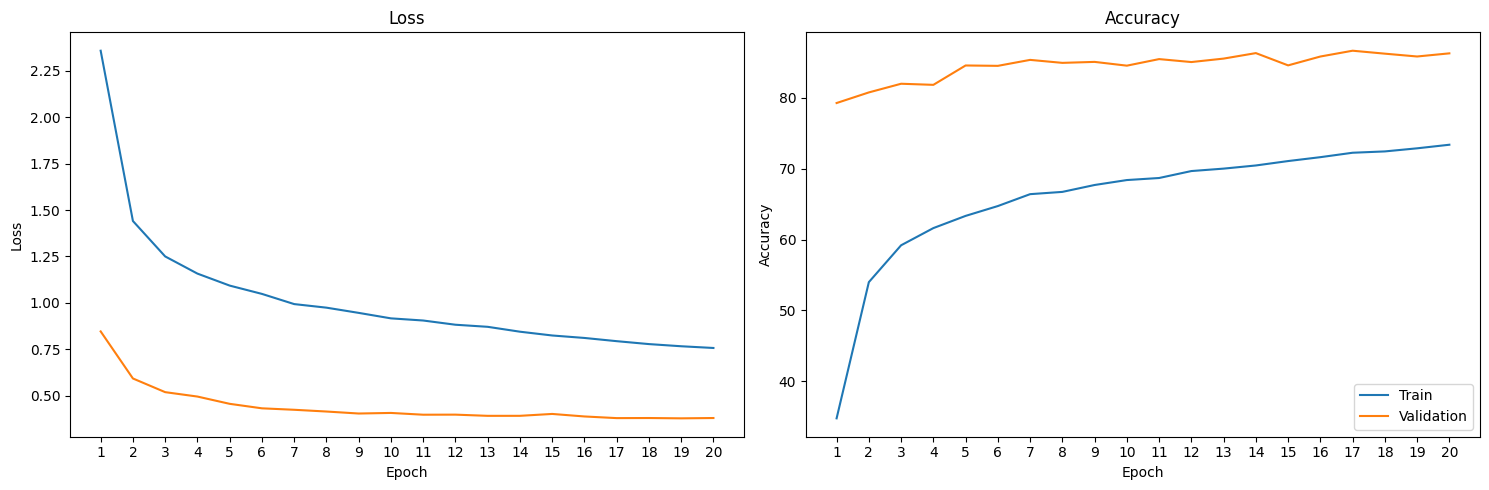

test_loss=0.3943264266463364 and test_accuracy =86.70212765957447


best_val_acc,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▄▅▆▆▆▇▇▇▇▇▇▇▇██████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▂▄▃▆▆▇▆▇▆▇▆▇█▆▇██▇█
val_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,86.6578
epoch,19


wandb: Agent Starting Run: 6vuu97al with config:
wandb: 	batch_size: 128
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3027923400954139
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.009899047399447048
wandb: 	momentum: 0.8971927776228925
wandb: 	num_conv_layers: 4
wandb: 	optimizer: SGD
wandb: 	weight_decay: 6.348764406058466e-05


Using device: cuda


Train Loss = 0.301 | Train Acc = 89.09% | Validation Loss = 0.345 | Validation Acc = 89.06% : 100%|██████████| 20/20 [12:47<00:00, 38.35s/it]


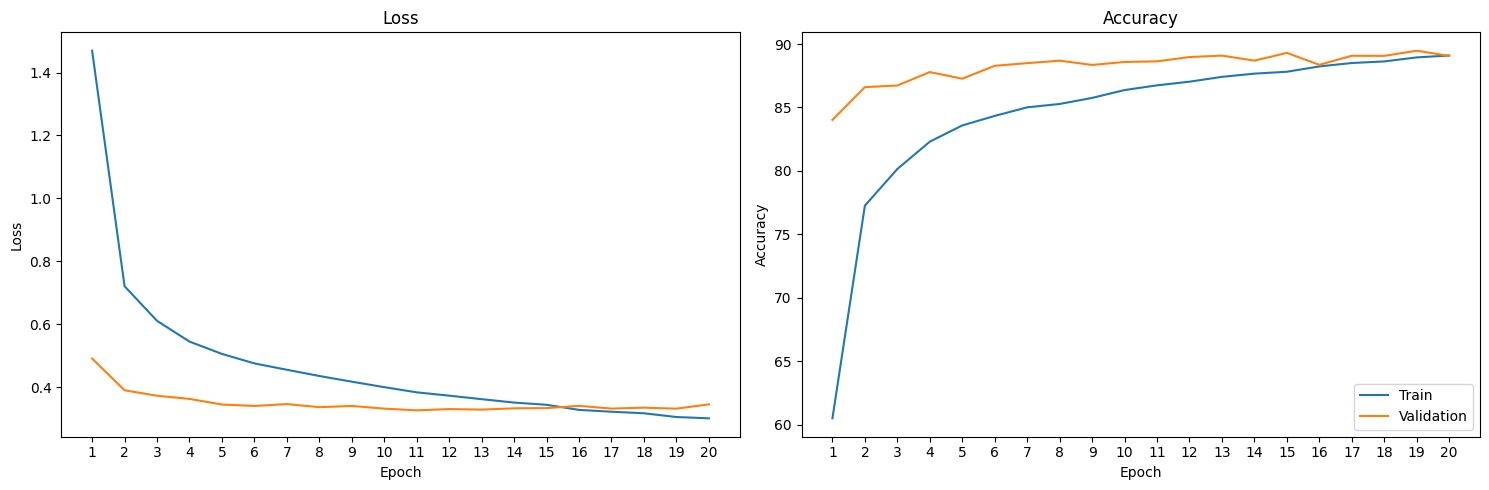

test_loss=0.3339905169139914 and test_accuracy =89.42021276595744


best_val_acc,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▆▆▇▇▇▇▇▇▇▇████████
train_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▄▆▅▆▇▇▇▇▇▇█▇█▇▇▇█▇
val_loss,█▄▃▃▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▂
best_val_acc,89.47252
epoch,19


wandb: Agent Starting Run: yj9vk2t1 with config:
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3758705272047549
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0002121246343172882
wandb: 	momentum: 0.9447814107755664
wandb: 	num_conv_layers: 4
wandb: 	optimizer: SGD
wandb: 	weight_decay: 6.09382228427349e-05


Using device: cuda


Train Loss = 0.506 | Train Acc = 83.82% | Validation Loss = 0.344 | Validation Acc = 88.98% : 100%|██████████| 20/20 [14:38<00:00, 43.90s/it]


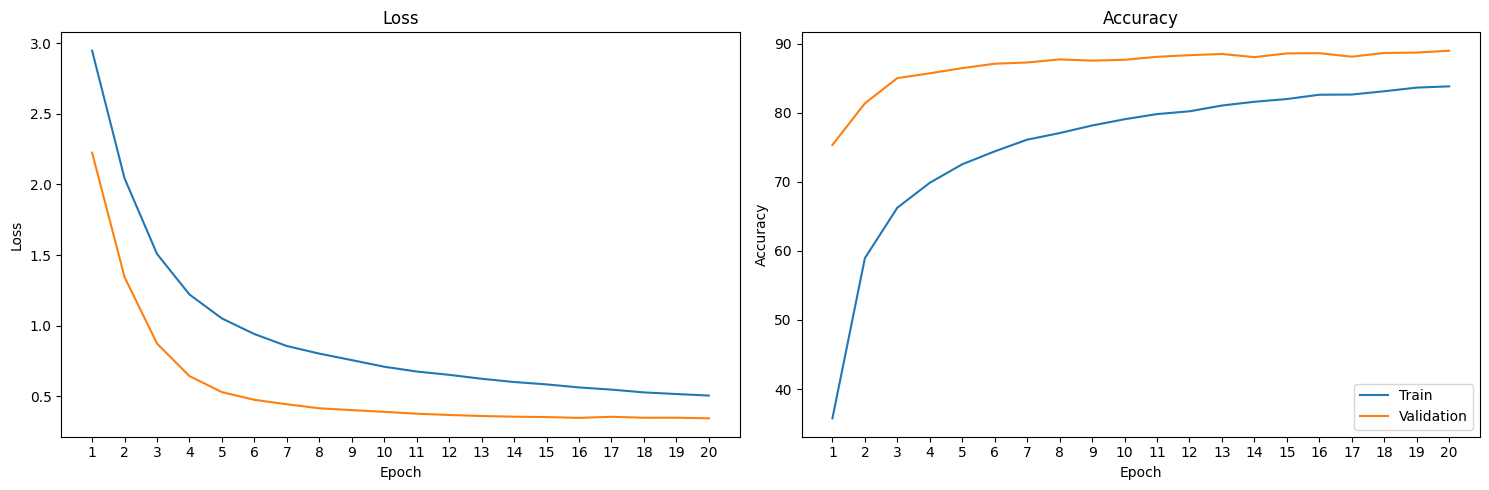

test_loss=0.35232374789256626 and test_accuracy =88.89893617021276


best_val_acc,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▄▅▆▆▇▇▇▇▇▇▇████████
train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇▇▇▇██████████
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,88.98493
epoch,19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: swxspi60 with config:
wandb: 	batch_size: 128
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.6244384788137922
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	kernel_size: 5
wandb: 	learning_rate: 8.660091868267701e-05
wandb: 	momentum: 0.9468601634390136
wandb: 	num_conv_layers: 4
wandb: 	optimizer: Adam
wandb: 	weight_decay: 1.61976061043905e-05


Using device: cuda


Train Loss = 2.526 | Train Acc = 22.52% | Validation Loss = 1.383 | Validation Acc = 78.17% : 100%|██████████| 20/20 [13:13<00:00, 39.69s/it]


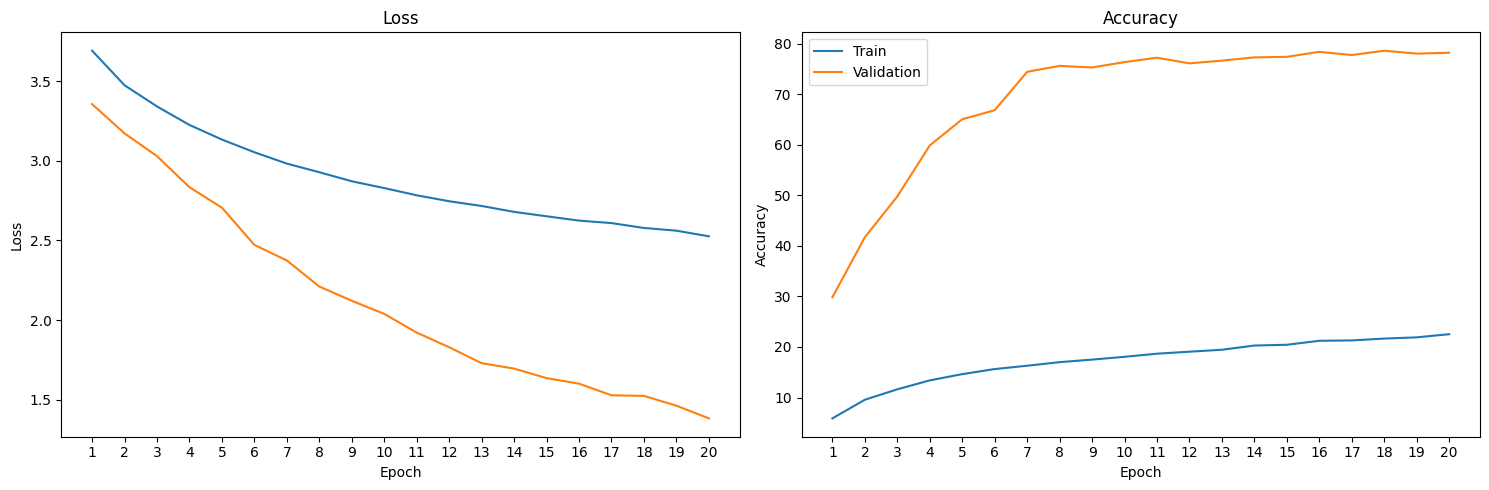

test_loss=1.5224475009100777 and test_accuracy =78.4627659574468


best_val_acc,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▃▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
val_acc,▁▃▄▅▆▆▇█████████████
val_loss,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁
best_val_acc,78.58156
epoch,19


wandb: Agent Starting Run: 5c7j0wlp with config:
wandb: 	batch_size: 32
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2787325310516639
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.008135088474248348
wandb: 	momentum: 0.911431762471666
wandb: 	num_conv_layers: 4
wandb: 	optimizer: SGD
wandb: 	weight_decay: 8.649536029783773e-06


Using device: cuda


Train Loss = 0.496 | Train Acc = 83.04% | Validation Loss = 0.341 | Validation Acc = 87.70% :  25%|██▌       | 5/20 [04:07<12:20, 49.38s/it]

In [ ]:
import wandb
def main():
    # First, make sure WandB is properly initialized
    wandb.login()  # Will prompt for API key if needed
    # Get current entity
    api = wandb.Api()
    current_entity = api.default_entity
    count=20
   # reset_wandb()
    # Create sweep configuration
    sweep_config = {
        'method': 'bayes',
        'metric': {
            'name': 'val_acc',
            'goal': 'maximize'
        },
        'parameters': {
            'learning_rate': {
                'distribution': 'log_uniform_values',
                'min': 1e-6,
                'max': 1e-2
            },
            'optimizer': {
                'values': ['Adam', 'SGD']
            },
            'batch_size': {
                'values': [8, 16, 32, 64, 128]
            },
            'num_conv_layers': {
                'values': [1, 2, 3, 4]
            },
            'filters': {
                'values': [32, 64]
            },
            'kernel_size': {
                'values': [3, 5]
            },
            'dropout_rate': {
                'distribution': 'uniform',
                'min': 0.2,
                'max': 0.7
            },
            'dense_units': {
                'values': [64, 128, 256]
            },
            'epochs': {
                'value': 20
            },
            'weight_decay': {
                'distribution': 'log_uniform_values',
                'min': 1e-8,
                'max': 1e-4
            },
            'momentum': {
                'distribution': 'uniform',
                'min': 0.8,
                'max': 0.95
            }
        }
    }

    # Initialize sweep
    sweep_id = wandb.sweep(
        sweep=sweep_config,
        project="sweep-cnn-emnist",
        entity=current_entity
    )

    print(f"Sweep ID: {sweep_id}")
    print(f"Starting {count} runs for hyperparameter sweep...")

    # Start the sweep agent
    wandb.agent(
        sweep_id,
        function=train_model,
        count=count,
    )

    print("Sweep completed!")
if __name__ == "__main__":
    main()

**Hyperparameter Sweep Analysis Summary: CNN on EMNIST**
After analyzing 10 hyperparameter sweep runs for a CNN on the EMNIST dataset, here are the key findings:

**Top Performers:**

1. Run 6vuu97al: 89.42% test accuracy
  * batch_size: 128
  * dense_units: 128
  * dropout_rate: 0.3027923400954139
  * epochs: 20
  * filters: 32
  * kernel_size: 5
  * learning_rate: 0.009899047399447048
  * momentum: 0.8971927776228925
  * num_conv_layers: 4
  * optimizer: SGD
  * weight_decay: 6.348764406058466e-05
2. Run yj9vk2t1: 88.90% test accuracy
  * batch_size: 64
  * dense_units: 128
  * dropout_rate: 0.3758705272047549
  * epochs: 20
  * filters: 32
  * kernel_size: 5
  * learning_rate: 0.0002121246343172882
  * momentum: 0.9447814107755664
  * num_conv_layers: 4
  * optimizer: SGD
  * weight_decay: 6.09382228427349e-05
3. Run rx48rm0g: 88.74% test accuracy
  * batch_size: 128
  * dense_units: 128
  * dropout_rate: 0.35996303545846653
  * epochs: 20
  * filters: 32
  * kernel_size: 5
  * learning_rate: 0.004429642712960431
  * momentum: 0.934179963151746
  * num_conv_layers: 4
  * optimizer: SGD
  * weight_decay: 1.522000219206854e-06

**Critical Hyperparameters (Biggest Impact)**:

1. **Learning Rate:** The most crucial factor, with optimal results between 0.001-0.01. Extremely low rates (<0.0001) caused significant performance drops (78% accuracy vs. 89% with proper rates).

2. **Network Depth:** Four convolutional layers consistently outperformed other configurations, with 6 of 7 such runs achieving >86% accuracy.

3. **Optimizer Choice:** Contrary to common assumptions, SGD outperformed Adam in most cases (6/6 SGD runs >82% accuracy), especially when combined with appropriate learning rates.

4. **Dropout Rate:** Medium values (0.30-0.38) provided the best regularization, while higher rates (>0.45) consistently reduced performance.

**Secondary Factors**
1. **Filter Count:** Models with 32 filters generally performed better than those with 64 filters.

2. **Batch Size:** Batch size of 128 showed slightly better results than smaller sizes, likely due to more stable gradient estimates.

**Less Significant Factors**
1. **Kernel Size:** Both 3×3 and 5×5 kernels worked reasonably well, with a slight preference for 5×5.

2. **Dense Units:** 128 units in the fully connected layer provided the best balance between performance and complexity.

**Recommended Configuration:**

For optimal EMNIST performance, use:

* 4 convolutional layers with 32 filters each
* SGD optimizer with learning rate between 0.004-0.01
* Dropout rate of 0.30-0.38
* Batch size of 128
* 5×5 kernel size
* 128 dense units in the classifier

This configuration balances model capacity with effective regularization, allowing the network to learn meaningful features from the EMNIST dataset without overfitting. The sweep clearly demonstrates that tuning learning rate, network depth, and dropout should be prioritized over other hyperparameters for this character recognition task.